In [1]:
import pandas as pd

# Load data from the Parquet file
df = pd.read_parquet("data_02_00.parquet")


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7137217 entries, 0 to 7137216
Data columns (total 61 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Event ID                      int64         
 1   Vehicle ID                    float64       
 2   Participant ID                int64         
 3   Participant type              object        
 4   Sex                           object        
 5   Driving license status        object        
 6   Years of driving experience   float64       
 7   Legal resolution              object        
 8   Killed                        object        
 9   Injured                       object        
 10  No safety equipment           object        
 11  Seat position                 object        
 12  Is at fault                   object        
 13  Under influence               object        
 14  Additional info               object        
 15  Vehicle condition             ob

In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import pandas as pd
import numpy as np

# Identify all columns containing 'ID' (to exclude them dynamically)
id_columns = [col for col in df.columns if 'ID' in col]

df['Quarter'] = df['Quarter'].dt.quarter

# Static blacklisted columns
manual_blacklist = [
    'Killed', 'Injured',
    'Last technical inspection', 'Date of event',
    'Date of birth', 'Event date', 'Accident type'
]

# Combined blacklist
blacklisted_columns = manual_blacklist + id_columns

# Sample 5000 rows and drop blacklisted
df_sample = df.drop(columns=blacklisted_columns).sample(n=5000, random_state=42)

# Features and target
X = df_sample.drop(columns=['Injury severity']).copy()
y = df_sample['Injury severity']

# Label encode target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Identify column types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Impute missing values
X[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[categorical_cols])
X[numerical_cols] = SimpleImputer(strategy='mean').fit_transform(X[numerical_cols])

# Label encode categorical columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

# Ensure numeric format
X = X.apply(pd.to_numeric)

# Define and evaluate model
model = XGBClassifier(eval_metric='mlogloss', random_state=42)
f1_scores = cross_val_score(model, X, y_encoded, cv=5, scoring='f1_macro')
print("Macro F1-scores (5 folds):", f1_scores)
print(f"Mean macro F1-score: {f1_scores.mean():.4f}\n")

# Train on full data to compute feature importance
model.fit(X, y_encoded)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display
print("Feature Importance:\n")
print(importance_df.to_string(index=False))




C:\Users\abudzyns\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Macro F1-scores (5 folds): [0.44796162 0.35993286 0.2647004  0.28100068 0.30817909]
Mean macro F1-score: 0.3324

Feature Importance:

                     Feature  Importance
            Participant type    0.169967
Protective equipment present    0.063600
            Legal resolution    0.041245
                Vehicle type    0.034378
             Under influence    0.030750
      Driving license status    0.027820
                Other causes    0.026889
           Intersection name    0.024114
      Intersection with road    0.024038
                         Sex    0.023350
    Distance to intersection    0.022216
             Production year    0.021393
     Distance marker (KM/HM)    0.019382
  Crash site characteristics    0.019119
                 Speed limit    0.018798
                      Street    0.018389
 Years of driving experience    0.018145
                 Road number    0.017833
               Vehicle model    0.017633
                  Crash type    0.017614
     

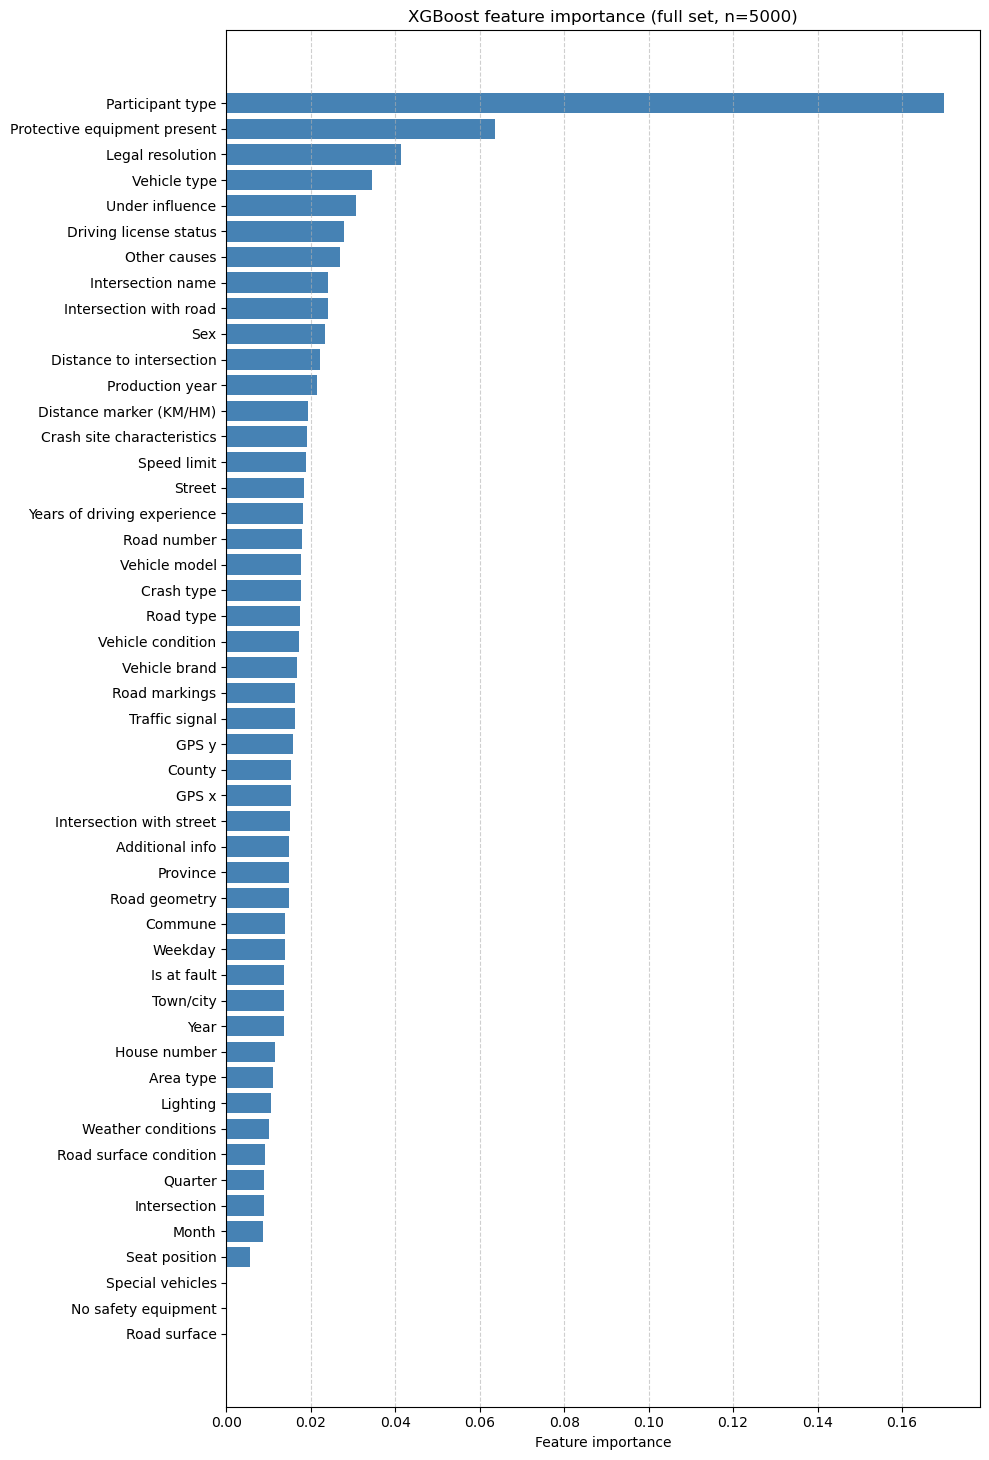

In [47]:
import matplotlib.pyplot as plt

# Sort and prepare the data
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(10, max(6, 0.3 * len(importance_df_sorted))))
plt.barh(importance_df_sorted['Feature'], importance_df_sorted['Importance'], color='steelblue')
plt.xlabel('Feature importance')
plt.title('XGBoost feature importance (full set, n=5000)')
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Add vertical gridlines
plt.tight_layout()
plt.show()